In [1]:
from __future__ import print_function
import numpy as np
import csv
import matplotlib.pyplot as plt
from matplotlib.image import imread
import os
#from pims import TiffStack
import torch
import skimage
import tensorflow as tf
import keras
#Basic NN packages
import keras.layers as kl
from keras.models import Sequential, Model
from keras.layers import Activation, Dense, BatchNormalization
from keras.layers import Dropout
from keras.layers import Flatten, Input, AveragePooling2D
from keras.constraints import maxnorm
from keras.optimizers import SGD, Adam
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
import keras.preprocessing.image as kpi
from keras.utils import plot_model

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

K.set_image_dim_ordering('th')


from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.regularizers import l2
from keras.models import load_model
from sklearn.metrics import roc_auc_score, roc_curve, precision_score, recall_score, f1_score, precision_recall_curve
from sklearn.utils.fixes import signature
from sklearn.utils.class_weight import compute_class_weight


/home/shared/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
tf.test.is_gpu_available()

True

In [3]:
def normalizeData(X):
    num_channels = np.shape(X)[1]
    train_mu = np.zeros(num_channels)
    for i in range(num_channels):
        train_mu[i] = np.mean(X[:,i,:,:])
        X[:,i,:,:] = X[:,i,:,:] - train_mu[i]
    return X, train_mu

In [4]:
def normalizeLabels(y):
    mu = np.mean(y,axis=0)
    sigma = np.std(y,axis=0)
    return mu, sigma

In [5]:
def getData():
    X_test = np.load("/home/jacobbedia/data/training_images/reg005cellimages.npy")
    X_test = np.append(X_test, np.load("/home/jacobbedia/data/training_images/reg006cellimages.npy"), axis=0)
    X_test = np.append(X_test, np.load("/home/jacobbedia/data/training_images/reg031cellimages.npy"), axis=0)
    y_test = np.load("/home/jacobbedia/data/labels/reg005expression_levels.npy")
    y_test = np.append(y_test, np.load("/home/jacobbedia/data/labels/reg006expression_levels.npy"), axis=0)
    y_test = np.append(y_test, np.load("/home/jacobbedia/data/labels/reg031expression_levels.npy"), axis=0)
    
    
    X_train = np.load('/home/jacobbedia/data/training_images/trainimages.npy')
    y_train = np.load('/home/jacobbedia/data/labels/trainlabels.npy')
    
    X_dev = np.load('/home/jacobbedia/data/training_images/devimages.npy')
    y_dev = np.load('/home/jacobbedia/data/labels/devlabels.npy')
    
    #for visualizing data in each channel
    """
    for i in range(200):
        implot = plt.imshow(X_train[i,:,:,0])
        plt.show()
        implot = plt.imshow(X_train[i,:,:,1])
        plt.show()
        implot = plt.imshow(X_train[i,:,:,2])
        plt.show()
    """    
    
    X_train = np.swapaxes(X_train, 2, 3)
    X_train = np.swapaxes(X_train, 1, 2)
    
    X_dev = np.swapaxes(X_dev, 2, 3)
    X_dev = np.swapaxes(X_dev, 1, 2)
    
    X_test = np.swapaxes(X_test, 2, 3)
    X_test = np.swapaxes(X_test, 1, 2)
       
   
    num_channels = np.shape(X_train)[1]
    X_train, train_mu = normalizeData(X_train)
    for i in range(num_channels):
        X_dev[:,i,:,:] = X_dev[:,i,:,:] - train_mu[i]
        X_test[:,i,:,:] = X_test[:,i,:,:] - train_mu[i]
        
    num_train = np.shape(X_train)[0]
    num_dev = np.shape(X_dev)[0]
    num_test = np.shape(X_test)[0]
    
    
    
    mu, sigma = normalizeLabels(y_train)
    mu = mu[np.newaxis,:]
    sigma = sigma[np.newaxis,:]
    print("mu_shape")
    print(np.shape(mu))
    print("sigma")
    print(np.shape(sigma))
    print(np.shape(y_train))
    y_train = (y_train - mu)/sigma
    print(np.shape(y_train))
    y_dev = (y_dev - mu)/sigma
    
    y_test = (y_test - mu)/sigma
    
    lymphocytes = [6,9,11,21,22,27,30,34,39,62,63,67,78]
    train_labels_parsed = np.zeros(num_train)[:,np.newaxis]
    dev_labels_parsed = np.zeros(num_dev)[:,np.newaxis]
    test_labels_parsed = np.zeros(num_test)[:,np.newaxis]
    #print("markers")
    #lymphocytes = [13,78]
    for marker in lymphocytes:
        print(marker)
        trainmark = y_train[:,marker][:,np.newaxis] > 0
        devmark = y_dev[:,marker][:,np.newaxis] > 0
        testmark = y_test[:,marker][:,np.newaxis] > 0
        train_labels_parsed = train_labels_parsed + trainmark
        dev_labels_parsed = dev_labels_parsed + devmark
        test_labels_parsed = test_labels_parsed + testmark
    
    train_labels_parsed = train_labels_parsed > 0
    dev_labels_parsed = dev_labels_parsed > 0
    test_labels_parsed = test_labels_parsed > 0
    
    
    print("wow")
    print(np.sum(train_labels_parsed) / np.shape(train_labels_parsed)[0])
    print(np.sum(dev_labels_parsed) / np.shape(dev_labels_parsed)[0])
    print(np.sum(test_labels_parsed) / np.shape(test_labels_parsed)[0])
    
    train_labels_parsed = keras.utils.to_categorical(train_labels_parsed, num_classes=2)
    dev_labels_parsed = keras.utils.to_categorical(dev_labels_parsed, num_classes=2)
    test_labels_parsed = keras.utils.to_categorical(test_labels_parsed, num_classes=2)
    return X_train, train_labels_parsed, X_dev, dev_labels_parsed, X_test, test_labels_parsed

In [6]:
def loadModel(num_classes, hyperparams, epochs):
    x = Input(shape=(num_classes,))
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=(3, 32, 32), padding='same', activation=None, kernel_constraint=maxnorm(hyperparams['maxnorm1'])))
    model.add(BatchNormalization(axis=1))
    model.add(Activation(kl.LeakyReLU(alpha=hyperparams['alpha1'])))
    model.add(Dropout(hyperparams['dropout1']))
    model.add(Conv2D(32, (3, 3), activation=None, padding='same', kernel_constraint=maxnorm(hyperparams['maxnorm2'])))
    #model.add(BatchNormalization(axis=1))
    model.add(Activation(kl.LeakyReLU(alpha=0.1)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(512, activation=None, kernel_constraint=maxnorm(3)))
    #model.add(BatchNormalization(axis=0))
    model.add(Activation(kl.LeakyReLU(alpha=hyperparams['alpha2'])))
    model.add(Dropout(hyperparams['dropout2']))
    #model.add(Dense(num_classes, activation='softmax'))
    model.add(Dense(num_classes, activation='linear'))
    # Compile model
    lrate = hyperparams['lr']
    decay = lrate/epochs
    #sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
    #model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    adam = Adam(lr=lrate, beta_1=hyperparams['beta1'], beta_2=hyperparams['beta2'])
    model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
    #print(model.summary())
    return model

In [7]:
def trainModel(model, X_train, y_train, X_test, y_test, epochs):
    y_integers = np.argmax(y_train, axis=1)
    class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
    d_class_weights = dict(enumerate(class_weights))
    print(d_class_weights)
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, verbose=1, batch_size=16, class_weight=d_class_weights)
    predictions = model.predict(X_test)
    np.save("/home/jacobbedia/data/basicNNmondaypreds", predictions)
    return history, model

In [8]:
def evaluateModel(model, X_test, y_test, hyperparams, iteration):
    scores = model.evaluate(X_test, y_test, verbose=0)
    print(scores)
    file = open("/home/jacobbedia/data/results12_6_18.txt", 'a')
    file.write("iteration {}\n".format(iteration))
    file.write(str(hyperparams) + '\n')
    file.write("validation error on reg007 is {}\n".format(scores[0]))
    file.close()
    #print("predictions")
    predictions = model.predict(X_test)
    print(predictions)
    """
    file = open("/home/jacobbedia/data/preds_iter{}".format(iteration), 'w')
    file.write(str(predictions))
    file.write("MSE was {}".format(scores[0]))
    file.write("F1 was {}".format(computeF1(predictions, y_test)))
    file.close
    """
    return predictions
    """print("predmean")
    print(np.mean(predictions))
    print("test")
    print(y_test)
    print("testmean")
    print(np.mean(y_test))
    plt.scatter(y_test, predictions)
    plt.show()"""

In [9]:
def lr_schedule(epoch):
    """Learning Rate Schedule
    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.
    # Arguments
        epoch (int): The number of epochs
    # Returns
        lr (float32): learning rate
    """
    lr = 1e-4
    if epoch > 45:
        lr *= 0.5e-5
    elif epoch > 35:
        lr *= 1e-3
    elif epoch > 25:
        lr *= 1e-2
    elif epoch > 15:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

In [10]:
def resnet_v1(input_shape, depth, num_classes=1):
    """ResNet Version 1 Model builder [a]
    Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
    Last ReLU is after the shortcut connection.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filters is
    doubled. Within each stage, the layers have the same number filters and the
    same number of filters.
    Features maps sizes:
    stage 0: 32x32, 16
    stage 1: 16x16, 32
    stage 2:  8x8,  64
    The Number of parameters is approx the same as Table 6 of [a]:
    ResNet20 0.27M
    ResNet32 0.46M
    ResNet44 0.66M
    ResNet56 0.85M
    ResNet110 1.7M
    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)
    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=True)
            x = kl.add([x, y])
            x = kl.LeakyReLU(alpha=.1)(x)
            #x = kl.add(Activation(kl.LeakyReLU(alpha=0.1)))
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(2,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [11]:
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder
    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)
    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-8))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = kl.LeakyReLU(alpha=.1)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = kl.LeakyReLU(alpha=.1)(x)
        x = conv(x)
    return x

In [12]:
def ResNetModel(X_train, y_train, X_dev, y_dev, X_test, y_test, hyperparams, iteration, epochs, depth):
    batch_size = 32  # orig paper trained all networks with batch_size=128
    num_classes = 2
    depth = depth
    input_shape = X_train.shape[1:]


    model = resnet_v1(input_shape=input_shape, depth=depth)

    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(lr=lr_schedule(0)),
                  metrics=['accuracy'])
    model.summary()

    # Prepare model model saving directory.
    save_dir = os.path.join("/home/jacobbedia/data", 'newsaved_models12_6day{}'.format(iteration))
    model_name = 'cifar10_%s_model.depth{}.h5'.format(depth)
    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
    filepath = os.path.join(save_dir, model_name)
    
    checkpoint = ModelCheckpoint(filepath=filepath,
                                 monitor='val_acc',
                                 verbose=1,
                                 save_best_only=True)
    
    lr_scheduler = LearningRateScheduler(lr_schedule)

    lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                                   cooldown=0,
                                   patience=5,
                                   min_lr=0.5e-6)

    callbacks = [checkpoint, lr_reducer, lr_scheduler]
    """
    datagen = ImageDataGenerator(
        # set input mean to 0 over the dataset
        featurewise_center=False,
        # set each sample mean to 0
        samplewise_center=False,
        # divide inputs by std of dataset
        featurewise_std_normalization=False,
        # divide each input by its std
        samplewise_std_normalization=False,
        # apply ZCA whitening
        zca_whitening=False,
        # epsilon for ZCA whitening
        zca_epsilon=1e-06,
        # randomly rotate images in the range (deg 0 to 180)
        rotation_range=180,
        # randomly shift images horizontally
        width_shift_range=0.0,
        # randomly shift images vertically
        height_shift_range=0.0,
        # set range for random shear
        shear_range=0.,
        # set range for random zoom
        zoom_range=0.,
        # set range for random channel shifts
        channel_shift_range=0.,
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        # value used for fill_mode = "constant"
        cval=0.,
        # randomly flip images
        horizontal_flip=True,
        # randomly flip images
        vertical_flip=False,
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(X_train)

    # Fit the model on the batches generated by datagen.flow().
    model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),
                        validation_data=(X_dev, y_dev),
                        epochs=epochs, verbose=1, workers=4,
                        callbacks=callbacks)
    """
    y_integers = np.argmax(y_train, axis=1)
    class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
    d_class_weights = dict(enumerate(class_weights))
    print(d_class_weights)
    history = model.fit(X_train, y_train,
                  batch_size=batch_size,
                  epochs=epochs,
                  validation_data=(X_dev, y_dev),
                  shuffle=True, class_weight = d_class_weights,
                  callbacks=callbacks)
    print("Loading best model")
    modelbest = resnet_v1(input_shape=input_shape, depth=depth)
    modelbest.load_weights(filepath)
    
    modelbest.compile(loss='categorical_crossentropy',
                  optimizer=Adam(lr=lr_schedule(0)),
                  metrics=['accuracy'])
    scores1 = model.evaluate(X_test,y_test, verbose=1)
    scores = modelbest.evaluate(X_test, y_test, verbose=1)
    print('Test loss:', scores[0])
    print('Test accuracy:', scores[1])
    print('Test1 accuracy:', scores1[1])
    finalpredictions = model.predict(X_test)
    optimizedpredictions = modelbest.predict(X_test)

    return history, finalpredictions, optimizedpredictions

In [13]:
def basicNN(X_train, normCD3train, X_dev, normCD3dev, X_test, y_test, hyperparams, iteration, epochs):
    print("iteration")
    print(iteration)
    print("hyperparameters")
    print(hyperparams)
    
    
    num_classes = normCD3dev.shape[1]
    model = loadModel(num_classes, hyperparams, epochs)
    history, model = trainModel(model, X_train, normCD3train, X_dev, normCD3dev, epochs)
    predictions = evaluateModel(model, X_test, y_test, hyperparams, iteration)
    scores = model2.evaluate(X_train, normCD3train, verbose=1)
    print('Test loss:', scores[0])
    print('Train accuracy:', scores[1])
    print('Test1 accuracy:', scores[1])
    
    
    scores = model2.evaluate(X_dev, normCD3dev, verbose=1)
    print('Test loss:', scores[0])
    print('dev accuracy:', scores[1])
    print('Test1 accuracy:', scores[1])
    
    
    scores = model2.evaluate(X_test, y_test, verbose=1)
    print('Test loss:', scores[0])
    print('Test accuracy:', scores[1])
    print('Test1 accuracy:', scores[1])
    return history, predictions

In [14]:
def visualizeResults(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    
    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    plt.savefig("ResNet20plot", dpi=1000)

In [15]:
def computeF1(predictions, y):
    #y = np.array([1.0,0.0,0.0])
    #print(np.shape(y))
    y_new = np.expand_dims(y, axis=0)
    #print(np.shape(y))
    #predictions = np.array([1.0,0.0,1.0])
    predictions_new = np.expand_dims(predictions, axis=0)
    #print(np.sum(predictions))
    #print(np.logical_and(predictions==y,predictions==1))
    prec = np.sum(np.logical_and(predictions==y,predictions==1)) / (np.sum(predictions))
    rec = np.sum(np.logical_and(predictions==y,predictions==1)) / (np.sum(np.logical_and(predictions==y,predictions==1)) + np.sum(np.logical_and(predictions!=y,predictions==0)))
    score = 2*(prec*rec)/(prec+rec)
    
    print("F1")
    print(score)   
    return score, prec, rec

In [16]:
def makePlots(y_test, prediction_list, model_list, metrics):
    return

In [21]:
def main(model_type):
    #for basic NN training
    """
    hyperparams = {}
    if model_type == "basic":
        hyperparams = {
            'maxnorm1' : 0,
            'maxnorm2' : 0,
            'alpha1' : 0,
            'alpha2' : 0,
            'dropout1' : 0,
            'dropout2' : 0,
            'lr' : 0,
            'beta1' : 0,
            'beta2' : 0
        }
    elif model_type == "ResNet":
        hyperparams = {
            'lr' : 0,
            'beta1' : 0,
            'beta2' : 0
        }
    
    iteration = 1
    """
    X_train, normCD3train, X_dev, normCD3dev, X_test, normCD3test = getData()
    
    #for debugging on subset of dataset
    """
    X_train = X_train[0:2000, :, :]
    normCD3train = normCD3train[0:2000, :]
    X_dev = X_dev[0:2000, :, :]
    normCD3dev = normCD3dev[0:2000, :]
    X_test = X_test[0:2000, :, :]
    normCD3test = normCD3test[0:2000,:]
    """
    
    
    """
    history_list = []
    prediction_list = np.zeros((np.shape(normCD3test)))
    print("prediction_list")
    print(np.shape(prediction_list))
    finalprediction_list = np.zeros((np.shape(normCD3test)))
    optpredlist = np.zeros((np.shape(normCD3test)))
    epochs = 50
    while(True):
        #if model_type == "basic":
        #random search method
        hyperparams['maxnorm1'] = np.random.randint(2,4)
        hyperparams['maxnorm2'] = np.random.randint(2,4)
        hyperparams['alpha1'] = np.power(10.0, np.random.randint(-6, -1))
        hyperparams['alpha2'] = np.power(10.0, np.random.randint(-6, -1))
        hyperparams['dropout1'] = np.random.uniform(0.0, 0.4)
        hyperparams['dropout2'] = np.random.uniform(0.3, 0.8)
        hyperparams['lr'] = np.random.uniform(1e-6, 1e-3)
        hyperparams['beta1'] = np.random.uniform(.8, 1.0)
        hyperparams['beta2'] = np.random.uniform(.9, 1.0)
        
        hyperparams['maxnorm1'] = 3
        hyperparams['maxnorm2'] = 3
        hyperparams['alpha1'] = .1
        hyperparams['alpha2'] = .1
        hyperparams['dropout1'] = .3
        hyperparams['dropout2'] = .5
        hyperparams['lr'] = 1e-4
        hyperparams['beta1'] = .85
        hyperparams['beta2'] = .95
        history, predictions = basicNN(X_train, normCD3train, X_dev, normCD3dev, X_test, normCD3test, hyperparams, iteration, epochs)
        finalprediction_list = predictions
        optpredlist = predictions
        #print("shapes")
        #print(np.shape(prediction_list))
        #visualizeResults(history)
        #history_list.append(history)
        #elif model_type == "ResNet":
        hyperparams['lr'] = np.random.uniform(1e-6, 1e-2)
        depths = [20]
        for depth in depths:
            history, finalpredictions,optimizedpredictions = ResNetModel(X_train, normCD3train, X_dev, normCD3dev, X_test, normCD3test, hyperparams, iteration, epochs, depth)
            visualizeResults(history)
            history_list.append(history)
            finalprediction_list = finalpredictions
            #np.append(finalprediction_list, finalpredictions, axis=1)
            optpredlist = optimizedpredictions
            #np.append(optpredlist, optimizedpredictions, axis=1)
            print("shapes")
            print(np.shape(finalprediction_list))
        if iteration >= 1:
            break
        iteration = iteration + 1
    
    X_train, normCD3train, X_dev, normCD3dev, X_test, normCD3test = getData()
    
    #newpreds(X_train, normCD3train, X_dev, normCD3dev, X_test, normCD3test)
    """
    
    #if skipping training and just want to generate plots, you can uncomment next three lines and load predictions
    finalprediction_list = np.load("/home/jacobbedia/data/newfinalnewpredictions.txt.npy")
    optpredlist = np.load("/home/jacobbedia/data/newoptimnewpredictions.txt.npy")
    model_list = ["BasicNN", "ResNet20", "ResNet32"]
    #remaining code is only for generating metrics and plots based on predictions
    
    
    """
    plt.figure(1)   
    metrics = np.zeros((3,4))
    for i in range(3):
        
        score, prec, recall = computeF1(finalprediction_list[:, i*2:i*2+2], normCD3test)
        met = [score, prec, recall]
        roc_AUC = roc_auc_score(normCD3test, finalprediction_list[:, i*2:i*2+2])
        print("roc_AUC")
        print(roc_AUC)
        y_for_AUC = normCD3test[:,0] < normCD3test[:,1]
        pred_for_AUC = finalprediction_list[:, i*2:i*2+2][:,1]
        fpr, tpr, thresholds = roc_curve(y_for_AUC, pred_for_AUC)
        metrics[i,:] = np.array([score,prec,recall,roc_AUC])
        plt.plot([0, 1], [0, 1], 'k--')
        plt.plot(fpr, tpr, label='{}(area = {:.3f})'.format(model_list[i], roc_AUC))
        
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.savefig("/home/jacobbedia/data/newnewnewfinalROCcurveNNresnet2032.pdf", dpi=1000)
    plt.show()
    plt.close()
    
    plt.figure(1)
    for i in range(3):
        
        score, prec, recall = computeF1(optpredlist[:, i*2:i*2+2], normCD3test)
        met = [score, prec, recall]
        roc_AUC = roc_auc_score(normCD3test, optpredlist[:, i*2:i*2+2])
        y_for_AUC = normCD3test[:,0] < normCD3test[:,1]
        pred_for_AUC = optpredlist[:, i*2:i*2+2][:,1]
        fpr, tpr, thresholds = roc_curve(y_for_AUC, pred_for_AUC)
        metrics[i,:] = np.array([score,prec,recall,roc_AUC])
        plt.plot([0, 1], [0, 1], 'k--')
        plt.plot(fpr, tpr, label='{}(area = {:.3f})'.format(model_list[i], roc_AUC))
        
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.savefig("/home/jacobbedia/data/newnewnewoptimROCcurveNNresnet2032.pdf", dpi=1000)
    plt.show()
    plt.close()
    """
    #3
    plt.figure(1)
    metrics = np.zeros((3,4))
    for i in range(3):
        
        #score, prec, recall = computeF1(prediction_list[:, i*2:i*2+2], normCD3test)
        y_for_AUC = normCD3test[:,0] < normCD3test[:,1]
        pred_for_AUC = finalprediction_list[:, i*2:i*2+2][:,1]
        print(pred_for_AUC)
        
        precmatrix, recallmatrix, thresholds = precision_recall_curve(y_for_AUC, pred_for_AUC)
        #prec = precision_score(normCD3test, prediction_list[:, i*2:i*2+2], labels=[pos_label], pos_label = 1)
        #recall = recall_score(normCD3test, prediction_list[:, i*2:i*2+2], labels=[pos_label], pos_label = 1)
        score = f1_score(y_for_AUC, (pred_for_AUC >= .5))
        print("scores{} {}".format(model_list[i], score))
        #met = [score, prec, recall]
        #print("met")
        #print(met)
        step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
        lab = '{} (F1 = {})'.format(model_list[i], score)
        plt.step(recallmatrix, precmatrix, label=lab, where='post')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall curve')
    plt.legend(loc='best')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.savefig("/home/jacobbedia/data/finalizedprec_reccurveNNresnet2032.pdf", dpi=1000)
    plt.show()
    plt.close()
    
    
    #4  
    plt.figure(1)
    metrics = np.zeros((3,4))
    for i in range(3):
        
        #score, prec, recall = computeF1(prediction_list[:, i*2:i*2+2], normCD3test)
        y_for_AUC = normCD3test[:,0] < normCD3test[:,1]
        pred_for_AUC = optpredlist[:, i*2:i*2+2][:,1]
        
        precmatrix, recallmatrix, thresholds = precision_recall_curve(y_for_AUC, pred_for_AUC)
        #prec = precision_score(normCD3test, prediction_list[:, i*2:i*2+2], labels=[pos_label], pos_label = 1)
        #recall = recall_score(normCD3test, prediction_list[:, i*2:i*2+2], labels=[pos_label], pos_label = 1)
        score = f1_score(y_for_AUC, (pred_for_AUC >= .5))
        print("scores{} {}".format(model_list[i], score))
        #met = [score, prec, recall]
        #print("met")
        #print(met)
        step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
        lab = '{} (F1 = {})'.format(model_list[i], score)
        plt.step(recallmatrix, precmatrix, label=lab, where='post')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall curve')
    plt.legend(loc='best')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.savefig("/home/jacobbedia/data/finalizedoptimprec_reccurveNNresnet2032.pdf", dpi=1000)
    plt.show()
    plt.close()
    
        
    
    """
    np.save("/home/jacobbedia/data/newfinalnewpredictions.txt", finalprediction_list)
    np.save("/home/jacobbedia/data/newoptimnewpredictions.txt", optpredlist)
    np.save("/home/jacobbedia/data/newnewmetrics.txt", metrics)
    """
    

In [23]:
finalprediction_list = np.load("/home/jacobbedia/data/newfinalnewpredictions.txt.npy")
optpredlist = np.load("/home/jacobbedia/data/newoptimnewpredictions.txt.npy")
X_train, normCD3train, X_dev, normCD3dev, X_test, y_test = getData()
print("F1, accuracy, roc test")
print(y_test)
print(optpredlist[:,0:2][:,0])
print(f1_score(y_test[:,0]<y_test[:,1], optpredlist[:,0:2][:,1]>=.5))
print(accuracy_score(y_test, optpredlist[:,0:2]))
print(roc_auc_score(y_test, optpredlist[:,0:2]))
"""
print("F1, accuracy, roc dev")
intercept = np.ones((np.shape(X_dev)[0],1))
X_dev = np.append(intercept, X_dev, axis=1)
devpreds = SVCmodel.predict(X_dev)
print(f1_score(y_dev, devpreds))
print(accuracy_score(y_dev, devpreds))
print(roc_auc_score(y_dev, devpreds))

intercept = np.ones((np.shape(X_test)[0],1))
X_test = np.append(intercept, X_test, axis=1)
testpreds = SVCmodel.predict(X_test)
print("F1, accuracy, roc test")
print(f1_score(y_test, testpreds))
print(accuracy_score(y_test, testpreds))
print(roc_auc_score(y_test, testpreds))
plots(testpreds, y_test)
"""

mu_shape
(1, 92)
sigma
(1, 92)
(58631, 92)
(58631, 92)
6
9
11
21
22
27
30
34
39
62
63
67
78
wow
0.7898551960566935
0.7915131668713331
0.7853664061615132
F1, accuracy, roc test
[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]
[ -99242.88   -98411.87  -114887.086 ... -216519.86  -243237.78
 -208634.12 ]
0.0


/home/shared/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in true_divide
/home/shared/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in true_divide
/home/shared/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide
/home/shared/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


NameError: name 'accuracy_score' is not defined

In [ ]:
def newpreds(X_train, y_train, X_dev, y_dev, X_test, y_test):
    filepath = "/home/jacobbedia/data/newsaved_models12_6day1/cifar10_%s_model.depth20.h5"
    print("loading best model")
    input_shape = X_train.shape[1:]
    depth=20
    model2 = resnet_v1(input_shape=input_shape, depth=depth)
    model2.load_weights(filepath)
    model2.compile(loss='categorical_crossentropy',
                  optimizer=Adam(lr=lr_schedule(0)),
                  metrics=['accuracy'])
    scores = model2.evaluate(X_train, y_train, verbose=1)
    print('Test loss:', scores[0])
    print('Train accuracy:', scores[1])
    print('Test1 accuracy:', scores[1])
    
    
    scores = model2.evaluate(X_dev, y_dev, verbose=1)
    print('Test loss:', scores[0])
    print('dev accuracy:', scores[1])
    print('Test1 accuracy:', scores[1])
    
    
    scores = model2.evaluate(X_test, y_test, verbose=1)
    print('Test loss:', scores[0])
    print('Test accuracy:', scores[1])
    print('Test1 accuracy:', scores[1])

mu_shape
(1, 92)
sigma
(1, 92)
(58631, 92)
(58631, 92)
6
9
11
21
22
27
30
34
39
62
63
67
78
wow
0.7898551960566935
0.7915131668713331
0.7853664061615132
[-478234.28 -482717.4  -513960.4  ... -231416.38 -210963.94 -211702.83]
scoresBasicNN 0.0
[0.841256   0.70878637 0.999206   ... 0.66863227 0.7027873  0.677418  ]
scoresResNet20 0.7822362488728585
[0.74323064 0.88775843 0.91142976 ... 0.28307512 0.37309134 0.22905721]
scoresResNet32 0.7597115608280995


/home/shared/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in true_divide
/home/shared/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in true_divide
/home/shared/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide
/home/shared/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


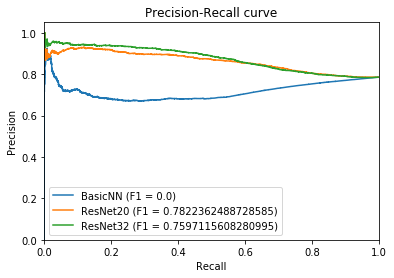

scoresBasicNN 0.0
scoresResNet20 0.8411808417212727
scoresResNet32 0.8123218135039288


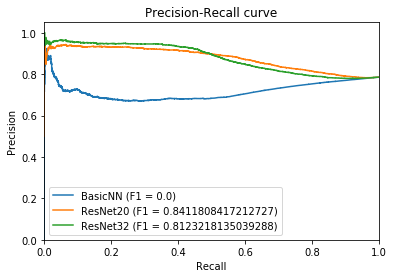

In [22]:
if __name__ == "__main__":
    
    seed = 7
    np.random.seed(seed)
    #processIncomingData()
    main("ResNet")

###### 